# Replicating the Internet Newsgroup Dataset experiment

> The objective of this study is to demonstrate that implementing Principal Component Analysis (PCA) prior to K-means clustering enhances the quality of the clustering outcomes. Additionally, this study aims to validate that the newly established lower bound approximation closely aligns with the objective value of the K-means algorithm, surpassing the precision of previous estimations.

> In our research, we aim to procure and present novel empirical evidence supporting the central assertion of the referenced paper: that principal components serve as continuous analogs to discrete cluster membership indicators in K-means clustering, resulting in enhanced performance. This exploration seeks to reinforce and expand upon the foundational findings, offering additional validation and potentially new insights into the efficacy of this method.

> This research seeks to replicate the findings of the study **K-means Clustering via Principal Component Analysis** utilizing the Internet Newsgroup dataset as the primary data source.


**Dataset Description**

The dataset under study is the Internet Newsgroup Dataset, encompassing approximately 20,000 documents that are evenly distributed across 20 distinct topics.

**Methodological Approach**

- Transformation of the dataset into a word-document matrix.
- Selection of 1,000 words based on their mutual information with documents, using an unsupervised approach.
- Development of four distinct combinations of topics for analysis.
- Generation of ten unique datasets for each topic combination, achieved through random sampling of documents.
- For combinations of two categories, 100 documents are randomly sampled.
- In the case of combinations involving five categories, two scenarios are considered:
    - A balanced sample consisting of 100 documents.
    - An unbalanced sample with varying document counts across categories (200, 140, 120, 100, 60).

Consequently, a total of 60 datasets are constructed, distributed across six different combinations:

- 20 datasets, each containing 200 documents, representing two topics (labeled as A2 and B2).
- 20 datasets, each with 500 documents, spanning five topics (designated as A5 and B5).
- 20 datasets, each comprising 620 documents, spread across five topics (identified as A5 and B5), with an unbalanced distribution among the topics.






**Metrics used**

In this study, we will use 2 different metrics to evaluate our results: inertia and clustering accuracy.

**Clustering Accuracy**: This metric assesses the degree to which the clustering algorithm correctly groups data points. We use it because we know the ground truth of our datasets.

**Inertia**: Also known as within-cluster sum of squares, inertia quantifies the compactness of clusters. It is calculated by summing the squared distances between each data point and the centroid of its assigned cluster. Lower values of inertia imply tighter and more defined clusters, indicating a better clustering performance.

In [ ]:
# If needed 

!pip install ucimlrepo
!pip install seaborn

In [ ]:
# Imports

from utils import *

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

from collections import Counter
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

from ucimlrepo import fetch_ucirepo

from scipy.sparse import save_npz, load_npz


import warnings
warnings.filterwarnings("ignore")

## Preprocessing steps

In [ ]:
def compute_mi(word_idx, X, topics):
    n_docs = X.shape[0]

    # Calculate P(topic)
    unique_topics, counts = np.unique(topics, return_counts=True)
    p_topic = dict(zip(unique_topics, counts / n_docs))

    # Calculate P(word)
    word_occurrences = X[:, word_idx].toarray().ravel()
    p_word = np.sum(word_occurrences) / n_docs
    p_not_word = 1 - p_word

    # Calculate P(word, topic) and MI
    mi = 0
    for topic in unique_topics:
        # P(word, topic)
        word_and_topic = np.sum((word_occurrences == 1) & (topics == topic)) / n_docs
        not_word_and_topic = np.sum((word_occurrences == 0) & (topics == topic)) / n_docs

        # Add to MI if probabilities are non-zero
        if word_and_topic > 0:
            mi += word_and_topic * np.log2(word_and_topic / (p_word * p_topic[topic]))
        if not_word_and_topic > 0:
            mi += not_word_and_topic * np.log2(not_word_and_topic / (p_not_word * p_topic[topic]))

    return mi

  '''
Implementation with scikit-learn method

def compute_mi(word_idx):
    word_occurrences = X[:, word_idx].toarray().ravel()
    mi = mutual_info_score(word_occurrences, np.array(topics))
    return mi

  '''

In [ ]:
# Pre-processing

with open("/content/drive/MyDrive/barrel.txt", "r") as file:
  data_lines = file.readlines()

paths = []
topics = []
texts = []

for line in data_lines:
    parts = line.split()
    paths.append(parts[0])
    topics.append(parts[1])
    text = ' '.join([word for i, word in enumerate(parts[2:]) if i % 3 == 0])
    texts.append(text)

# Construct word-document frequency matrix
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(texts)
words = vectorizer.get_feature_names_out()

In [ ]:
# -- DO NOT EXECUTE THIS CELL, 20mn to run --

# Select top 1000 words based on mutual information
mi_scores = [compute_mi(i) for i in range(len(words))]
top_word_indices = np.argsort(mi_scores)[-1000:]
selected_words = [words[i] for i in top_word_indices]

# Update the word-document matrix to only consider the top 1000 words
X_selected = X[:, top_word_indices]

# Save the word-document matrix to avoid several computations of top 1000 MI
save_path = '/content/drive/MyDrive/X_selected_newsgroup_1000.npz'
save_npz(save_path, X_selected)

In [ ]:
# X_selected is an array 19K x 1000 corresponding to all documents and the 1000 most significant words
save_path = '/content/drive/MyDrive/X_selected_newsgroup_1000.npz'
X_selected = load_npz(save_path)
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_selected)

# Convert to DataFrame and add labels
df = pd.DataFrame(X_tfidf.toarray())
df['groups'] = topics

## Creation of the sub datasets for the experiment

In [ ]:
def create_datasets(df, topic_list, dataset_prefix, balanced=True, n_sample=100):
    '''
    Method to create 10 datasets per topics combination
    '''

    for i in range(1, 11):
        samples = []
        if balanced:
            for topic in topic_list:
                samples.append(df[df.iloc[:, -1] == topic].sample(n=n_sample))
        else:
            available_samples = [200, 140, 120, 100, 60]
            for topic in topic_list:
                chosen_value = random.choice(available_samples)
                available_samples.remove(chosen_value)
                samples.append(df[df.iloc[:, -1] == topic].sample(n=chosen_value))

        new_dataset = pd.concat(samples, ignore_index=True)
        dsets[f'{dataset_prefix}_{i}'] = new_dataset

# Initialize the dictionary to store datasets
dsets = {}

# Create datasets for different combinations of topics
create_datasets(df, ['alt.atheism', 'comp.graphics'], 'A2')
create_datasets(df, ['talk.politics.mideast', 'talk.politics.misc'], 'B2')
create_datasets(df, ['comp.graphics', 'rec.motorcycles', 'rec.sport.baseball', 'sci.space', 'talk.politics.mideast'], 'A5_balanced')
create_datasets(df, ['comp.graphics', 'comp.os.ms-windows.misc', 'rec.autos', 'sci.electronics', 'talk.politics.misc'], 'B5_balanced')
create_datasets(df, ['comp.graphics', 'rec.motorcycles', 'rec.sport.baseball', 'sci.space', 'talk.politics.mideast'], 'A5_unbalanced', balanced=False)
create_datasets(df, ['comp.graphics', 'comp.os.ms-windows.misc', 'rec.autos', 'sci.electronics', 'talk.politics.misc'], 'B5_unbalanced', balanced=False)


## Lower Bound and Inertia

In [ ]:
def compute_lower_bound(data, K):
    """Compute the lower bound for the dataset."""
    ny2 = len(data) * np.var(data, axis=0).sum()
    Y = data - data.mean(axis=0)
    cov_matrix = np.dot(Y, Y.T)
    eigenvalues = np.linalg.eigvals(cov_matrix)
    sorted_eigenvalues = np.sort(eigenvalues)[::-1]
    return ny2 - sum(sorted_eigenvalues[:K-1])

def find_best_kmeans(data, K, iterations=20):
    """Find the KMeans model with the lowest inertia."""
    best_inertia = float('inf')
    best_kmeans = None
    for _ in range(iterations):
        kmeans = KMeans(k=K)
        kmeans.fit(data)
        if kmeans.inertia_ < best_inertia:
            best_inertia = kmeans.inertia_
            best_kmeans = kmeans
    return best_inertia

def analyze_dataset(name, nb_clusters):
    """Analyze a given dataset."""
    lower_bounds = []
    inertia_list = []
    percentage_difference = []

    for i in range(1, 11):
        dataset_name = f"{name}_{i}"
        data = dsets[dataset_name].iloc[:, :-1].values  # Excluding last column as it's not a feature

        lhs_bound = compute_lower_bound(data, nb_clusters)
        lower_bounds.append(lhs_bound)

        best_inertia = find_best_kmeans(data, nb_clusters)
        inertia_list.append(best_inertia)

        pd = ((best_inertia - lhs_bound) / ((best_inertia + lhs_bound) / 2)) * 100
        percentage_difference.append(pd.real)

    average_pd = np.mean(percentage_difference)
    print(f"Averaged Percentage Difference: {average_pd:.2f} %")
    return inertia_list, lower_bounds, average_pd

In [ ]:
# Main code
datasets = ['A2', 'B2', 'A5_balanced', 'B5_balanced', 'A5_unbalanced', 'B5_unbalanced']
inertia_total = []
lower_bounds_total = []
percentage_difference_total = []

for name in datasets:
    nb_clusters = 2 if name in ['A2', 'B2'] else 5
    inertia_list, lower_bounds, average_pd = analyze_dataset(name, nb_clusters)
    inertia_total.append(inertia_list)
    lower_bounds_total.append(lower_bounds)
    percentage_difference_total.append(average_pd)



Averaged Percentage Difference: 0.73 %
Averaged Percentage Difference: 0.71 %
Averaged Percentage Difference: 1.50 %
Averaged Percentage Difference: 1.63 %
Averaged Percentage Difference: 1.46 %
Averaged Percentage Difference: 1.53 %


In [ ]:
# Processing
inertia_total = np.array(inertia_total).real
lower_bounds_total = np.array(lower_bounds_total).real
percentage_difference_total = np.array(percentage_difference_total).real
inertia_total = [num for num in inertia_total]
lower_bounds_total = [num for num in lower_bounds_total]
percentage_difference_total = [num for num in percentage_difference_total]

# Dataframe construction
row_names = [f"{ds} {metric}" for ds in datasets for metric in ['lower bound', 'inertia']]
col_names = [str(i) for i in range(1, 11)] + ["percentage difference"]
df = pd.DataFrame(index=row_names, columns=col_names)

for i, row_name in enumerate(df.index):
    if "inertia" in row_name:
        df.loc[row_name, :-1] = inertia_total[i // 2]
    else:
        df.loc[row_name, :-1] = lower_bounds_total[i // 2]
df["percentage difference"] = np.repeat(percentage_difference_total, 2)

In [ ]:
df.head(12)

,1,2,3,4,5,6,7,8,9,10,percentage difference
A2 lower bound,180.731806,183.199668,183.83445,182.022368,180.577612,182.872493,183.51871,182.213289,183.485734,183.588595,0.727175
A2 inertia,182.103449,184.299309,184.963825,183.489017,182.035054,184.082818,184.735133,183.281855,185.293899,185.086812,0.727175
B2 lower bound,178.601036,179.53315,180.237381,180.020666,177.234353,179.956517,180.37736,180.938639,179.596867,178.610612,0.709714
B2 inertia,180.761413,180.67901,181.198357,180.653251,178.091888,181.309819,181.951548,181.997832,181.933639,179.324443,0.709714
A5_balanced lower bound,442.364819,444.362022,442.934346,441.79437,445.920494,441.95866,445.131732,442.844744,445.689956,444.443921,1.496937
A5_balanced inertia,449.154607,450.805697,449.815741,448.256763,452.389947,447.958351,452.348722,449.935311,452.625534,451.085178,1.496937
B5_balanced lower bound,449.430768,448.71803,449.08755,450.197798,447.255973,449.200271,449.467848,448.367439,447.577471,447.083727,1.627559
B5_balanced inertia,455.233532,456.272287,456.361636,457.625743,455.445408,457.423608,457.016501,455.540838,453.576674,455.51169,1.627559
A5_unbalanced lower bound,552.319766,553.068675,543.194774,552.329337,549.118651,544.591522,550.232189,547.367309,547.301249,551.537,1.461269
A5_unbalanced inertia,560.074757,561.205064,550.622285,560.554694,558.101445,552.240197,558.719177,555.416896,554.850025,560.119656,1.461269


In [ ]:
inertia_values = np.array(inertia_total)
lower_values = np.array(lower_bounds_total)
print(inertia_values.shape, lower_values.shape)

(6, 10) (6, 10)


In [ ]:
# Pre-steps for the figure
avg_inertia = np.mean(inertia_values, axis=1)
avg_lower = np.mean(lower_values, axis=1)
inertia_values_2 = inertia_values[:2,:]
avg_lower_2 = np.mean(lower_values[:2,:], axis=1)
avg_inertia_2 = np.mean(inertia_values[:2,:], axis=1)

labels = ['A2', 'B2', 'A5_balanced', 'A5_unbalanced', 'B5_balanced', 'B5_unbalanced']
labels_2 = ['A2', 'B2']

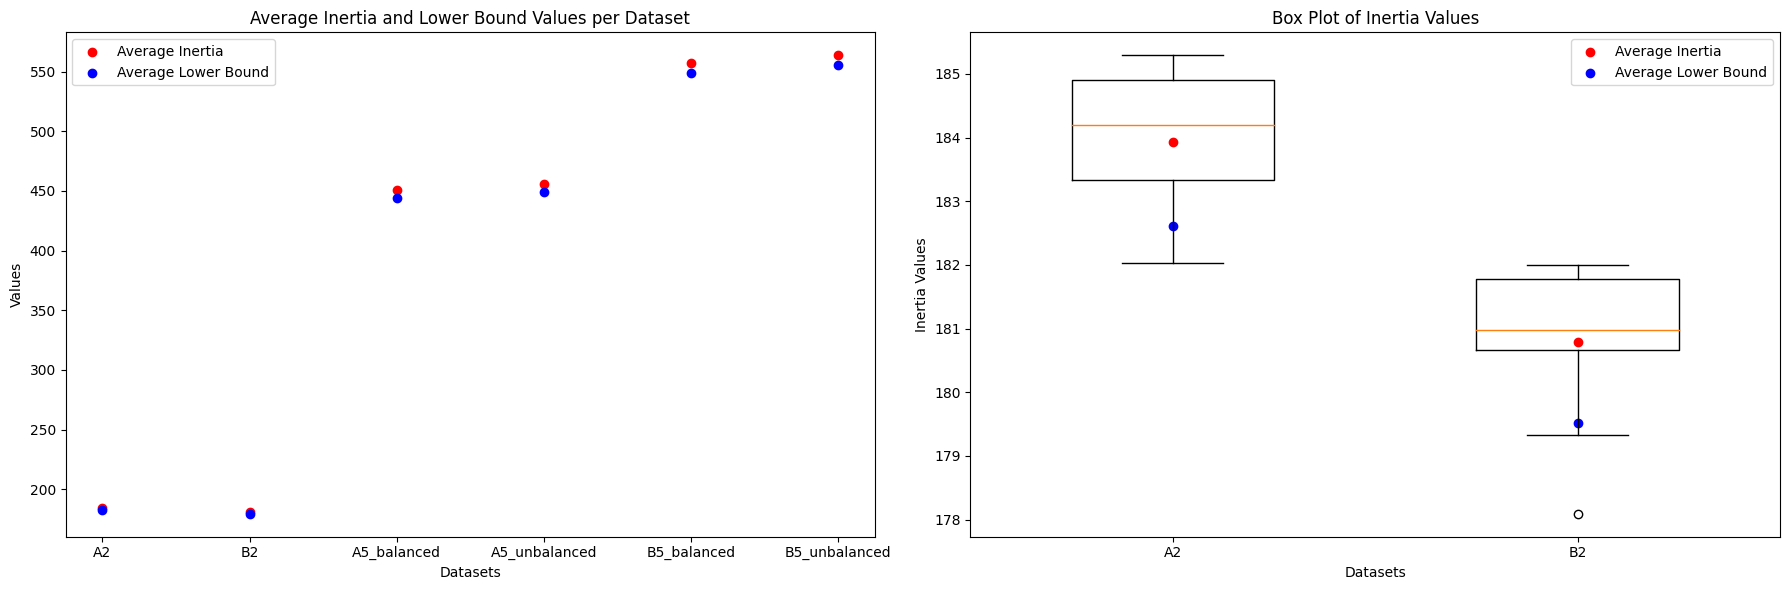

In [ ]:
# Create the figure and the two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# First subplot for the scatter plot of averages
for i in range(inertia_values.shape[0]):
    ax1.scatter([i], avg_inertia[i], color='red', label='Average Inertia' if i==0 else "")
    ax1.scatter([i], avg_lower[i], color='blue', label='Average Lower Bound' if i==0 else "")

ax1.set_title('Average Inertia and Lower Bound Values per Dataset')
ax1.set_xlabel('Datasets')
ax1.set_ylabel('Values')
ax1.legend()
ax1.set_xticks(range(inertia_values.shape[0]))  # Set x-ticks to represent each dataset
ax1.set_xticklabels(labels)


# Second subplot for the box plot
for i in range(inertia_values_2.shape[0]):
    ax2.boxplot(inertia_values_2[i], positions=[i], widths=0.5)
    ax2.scatter([i], avg_inertia_2[i], color='red', label='Average Inertia' if i==0 else "")
    ax2.scatter([i], avg_lower_2[i], color='blue', label='Average Lower Bound' if i==0 else "")

ax2.set_title('Box Plot of Inertia Values')
ax2.set_xlabel('Datasets')
ax2.set_ylabel('Inertia Values')
ax2.legend()
ax2.set_xticks(range(inertia_values_2.shape[0]))  # Set x-ticks to represent each dataset
ax2.set_xticklabels(labels_2)

plt.tight_layout()
plt.show()

**Analysis Methodology and Findings**

In our study, each dataset underwent 20 iterations of the K-means clustering process. This repetition aimed to mitigate the potential impacts of varying initial conditions. Concurrently, we calculated the new lower bound as delineated in the paper "K-means Clustering via Principal Component Analysis."

Our analysis revealed that the newly proposed lower bound is consistently proximate to the minimal inertia values obtained over the 20 iterations. This proximity is noteworthy, with the deviation consistently contained within a 1.7% margin.

These findings lend support to the hypotheses presented in the aforementioned paper. They illustrate that the new lower bound maintains a more significant correlation with the minimal inertia values than the two alternative bounds discussed in prior research. Specifically, the other bounds, as cited in Zha et al. (2001), indicated a percentage difference exceeding 1% for the A2 and B2 combinations. In contrast, the new bound demonstrated a discrepancy of less than 0.7%, underscoring its enhanced precision and relevance in clustering analysis.

We propose a theoretical explanation in the report.

## PCA+K-means method


In this experiment, our focus will be on computing the average accuracy across the different dataset combinations, considering both centered and uncentered scenarios.

To explore the impact of dimensionality reduction, we will implement Principal Component Analysis (PCA) as a preliminary step. This process will range from the absence of PCA to a reduction down to five dimensions. This approach will allow us to assess the effectiveness of PCA in enhancing clustering accuracy under different dimensional settings.

In [ ]:
def perform_clustering(data, num_clusters):
    """
    Perform KMeans clustering on the given data.
    """
    kmeans = KMeans(k=num_clusters)
    kmeans.fit(data)
    return kmeans

def calculate_accuracies(data, labels_num, dimensions, nb_clusters):
    """
    Calculate the clustering accuracies for different PCA dimensions,
    both centered and uncentered.
    """
    accuracy_centered, accuracy_uncentered = [], []

    for dimension in dimensions:
        # Centered case
        data_centered = data - data.mean(axis=0)
        pca_centered = PCA(n_components=dimension)
        data_transformed_centered = pca_centered.fit_transform(data_centered)
        kmeans_centered = perform_clustering(data_transformed_centered, nb_clusters)
        accuracy_centered.append(clustering_accuracy(labels_num, kmeans_centered.labels, data_centered))

        # Uncentered case
        pca_uncentered = PCA(n_components=dimension)
        data_transformed_uncentered = pca_uncentered.fit_transform(data)
        kmeans_uncentered = perform_clustering(data_transformed_uncentered, nb_clusters)
        accuracy_uncentered.append(clustering_accuracy(labels_num, kmeans_uncentered.labels, data))

    return accuracy_centered, accuracy_uncentered

In [ ]:
def calculate_average_accuracies(dsets, dataset_types, versions, pca_dimensions):
    """
    Calculate average accuracies for each dataset type over different versions.

    Parameters:
    - dsets: dict
      Dictionary containing all datasets.
    - dataset_types: list
      List of dataset types (e.g., ['A5_unbalanced', 'B2_balanced', ...]).
    - versions: list
      List of dataset versions (e.g., [1, 2, ..., 10]).
    - pca_dimensions: list
      List of PCA dimensions to be tested, including None for no PCA.

    Returns:
    - pd.DataFrame
      A DataFrame with the average accuracies for each dataset type.
    """
    results = []

    for dataset_type in dataset_types:
        accuracies_centered = {dim: [] for dim in pca_dimensions}
        accuracies_uncentered = {dim: [] for dim in pca_dimensions}

        for version in versions:
            dataset_name = f"{dataset_type}_{version}"
            data = dsets[dataset_name].iloc[:, :-1].values
            labels = dsets[dataset_name]['groups']

            nb_clusters = 2 if '2' in dataset_type else 5
            mapping = create_label_mapping(labels)
            labels_num = map_labels(labels, mapping)

            for dimension in pca_dimensions:
                # Centered case
                data_centered = data - data.mean(axis=0) if dimension is not None else data
                pca_centered = PCA(n_components=dimension) if dimension is not None else None
                data_transformed_centered = pca_centered.fit_transform(data_centered) if dimension is not None else data_centered
                kmeans_centered = perform_clustering(data_transformed_centered, nb_clusters)
                accuracies_centered[dimension].append(clustering_accuracy(labels_num, kmeans_centered.labels))

                # Uncentered case
                pca_uncentered = PCA(n_components=dimension) if dimension is not None else None
                data_transformed_uncentered = pca_uncentered.fit_transform(data) if dimension is not None else data
                kmeans_uncentered = perform_clustering(data_transformed_uncentered, nb_clusters)
                accuracies_uncentered[dimension].append(clustering_accuracy(labels_num, kmeans_uncentered.labels))

        # Averaging accuracies for the dataset type
        avg_accuracies_centered = {dim: np.mean(accuracies) for dim, accuracies in accuracies_centered.items()}
        avg_accuracies_uncentered = {dim: np.mean(accuracies) for dim, accuracies in accuracies_uncentered.items()}
        results.append([dataset_type, avg_accuracies_centered, avg_accuracies_uncentered])

    # Creating DataFrame
    columns = ['Dataset Type', 'Average Accuracy Centered', 'Average Accuracy Uncentered']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results


def format_table(average_accuracies_df):
    # Create a dictionary to hold the formatted data
    formatted_data = {'Dim': []}
    for dataset_type in average_accuracies_df['Dataset Type'].unique():
        formatted_data[f'{dataset_type}-B'] = []  # Balanced
        formatted_data[f'{dataset_type}-U'] = []  # Unbalanced

    # Iterate over each row and fill the dictionary
    for _, row in average_accuracies_df.iterrows():
        for dim in row['Average Accuracy Centered'].keys():  # Assuming the same dimensions are used for centered and uncentered
            if dim not in formatted_data['Dim']:
                formatted_data['Dim'].append(dim)
            acc_centered = row['Average Accuracy Centered'][dim]
            acc_uncentered = row['Average Accuracy Uncentered'][dim]
            formatted_data[f'{row["Dataset Type"]}-B'].append(f'{acc_uncentered:.2f}/{acc_centered:.2f}')
            formatted_data[f'{row["Dataset Type"]}-U'].append(f'{acc_uncentered:.2f}/{acc_centered:.2f}')

    # Create a DataFrame from the formatted data
    formatted_df = pd.DataFrame(formatted_data)
    formatted_df.set_index('Dim', inplace=True)

    return formatted_df

In [ ]:
dataset_types = ['A2', 'B2', 'A5_balanced', 'B5_balanced', 'A5_unbalanced', 'B5_unbalanced']
versions = list(range(1, 11))
pca_dimensions = [None, 40, 20, 10, 6, 5] # None represents no PCA

# Calculate average accuracies
average_accuracies_df = calculate_average_accuracies(dsets, dataset_types, versions, pca_dimensions)

In [ ]:
formatted_df = format_table(average_accuracies_df)
formatted_df = formatted_df.fillna(1000)
formatted_df = formatted_df.drop(columns=['A2-U', 'B2-U', 'B5_balanced-U', 'A5_balanced-U', 'A5_unbalanced-B', 'B5_unbalanced-B'])
formatted_df = formatted_df.rename(columns={'A2-B': 'A2', 'B2-B': 'B2', 'A5_balanced-B': 'A5-B', 'B5_balanced-B': 'B5-B', 'A5_unbalanced-U': 'A5-U', 'B5_unbalanced-U': 'B5-U',})
formatted_df.index = formatted_df.index.fillna(1000)
formatted_df.index = formatted_df.index.astype(int)
formatted_df = formatted_df.iloc[::-1]

formatted_df.head(6)


,A2,B2,A5-B,B5-B,A5-U,B5-U
Dim,,,,,,
5,0.79/0.93,0.70/0.66,0.74/0.77,0.63/0.62,0.72/0.74,0.64/0.64
6,0.84/0.73,0.72/0.71,0.78/0.79,0.65/0.63,0.67/0.72,0.64/0.63
10,0.84/0.79,0.70/0.65,0.77/0.77,0.60/0.63,0.71/0.70,0.64/0.62
20,0.87/0.88,0.67/0.63,0.69/0.73,0.58/0.54,0.68/0.73,0.60/0.59
40,0.80/0.80,0.68/0.67,0.67/0.72,0.56/0.58,0.69/0.70,0.58/0.61
1000,0.87/0.87,0.64/0.70,0.72/0.72,0.56/0.60,0.73/0.75,0.61/0.57


**Analytical Overview and PCA implementation**

In the presented analysis, the term 'Dim' refers to the level of reduction achieved through Principal Component Analysis (PCA), with 1000 implying no PCA pre-step. The table differentiates results between the uncentered case (left) and the centered case (right).

PCA is employed as a method for reducing dimensionality while preserving the most significant features of the dataset. It accomplishes this by transforming the original data into a new set of orthogonal (uncorrelated) variables, known as principal components (PCs), which capture the maximum variance present in the data. The primary advantage of PCA in dimension reduction lies in its ability to decrease computational complexity and minimize noise, thus facilitating more efficient and accurate clustering by focusing on the most variance-accounting components.

Centering the data, which involves subtracting the mean from each data dimension, is a critical step before applying PCA. This is because PCA's performance is sensitive to the scale of the variables; without centering, variables with larger scales may disproportionately influence PCA, leading to a misrepresentation of the data's underlying structure.

Our results consistently show that using centered data yields better outcomes. Furthermore, we observed that employing PCA for dimensionality reduction invariably enhances clustering accuracy, with the sole exception being the A5 unbalanced case.

These findings align with the results reported in the referenced paper although the increase is far more modest. Through this detailed analysis, we reaffirm the benefits of PCA in clustering while providing a more comprehensive understanding of its effects under varied conditions.

## Expanding exploration using classic datasets

> Building upon the findings from the reference paper, our next objective is to apply the PCA + K-means methodology to other well-known datasets, aiming to validate and reinforce our results. Additionally, we plan to investigate the relationship between inertia and clustering accuracy as the degree of PCA dimension reduction increases.

**Methodological Approach**

For this phase of the study, we will exclusively focus on centered data. To ensure the reliability of our findings and minimize the influence of initialization variables, we will compute the average values of accuracy and inertia across 20 iterations for each dataset. The analysis will be conducted under three distinct scenarios: without any PCA pre-step, with a reduction to half the number of original features using principal components, and with reductions to only three and two principal components, respectively. This methodical approach will allow us to thoroughly assess the impact of varying levels of dimensionality reduction on the clustering performance.

> Wine dataset: 178 points, 13 features, 3 classes

In [ ]:
# Retrieve the data
wine = fetch_ucirepo(id=109)
X = np.array(wine.data.features)
y = np.array(wine.data.targets).ravel()

n_clusters = 3
X_centered = X - X.mean()
acc_total = []
inertia_total = []

for dimension_reduction in [None, X.shape[1] // 2, 3, 2]:
  acc_ls = []
  inertia_ls = []
  for _ in range(20):
    if dimension_reduction == None:
      kmeans = KMeans(k=n_clusters)
      kmeans.fit(X_centered)
      acc = clustering_accuracy(y, kmeans.labels)
      acc_ls.append(acc)
      inertia_ls.append(kmeans.inertia_)
    else:
      pca = PCA(n_components=dimension_reduction)
      X_PCA = pca.fit_transform(X_centered)
      kmeans = KMeans(k=n_clusters)
      kmeans.fit(X_PCA)
      acc = clustering_accuracy(y, kmeans.labels)
      acc_ls.append(acc)
      inertia_ls.append(kmeans.inertia_)


  accu = np.mean(acc_ls)
  inerti = np.mean(inertia_ls)
  acc_total.append(accu)
  inertia_total.append(inerti)
  print(f"PCA reduction = {dimension_reduction}, Accuracy={accu:.3f}, Inertia={inerti:.3f}")

PCA reduction = None, Accuracy=0.693, Inertia=2501876.309
PCA reduction = 6, Accuracy=0.701, Inertia=2383714.348
PCA reduction = 3, Accuracy=0.699, Inertia=2408365.277
PCA reduction = 2, Accuracy=0.697, Inertia=2446147.107


> Glass Dataset: 214 points, 9 features, 7 classes

In [ ]:
# Retrieve the data
glass_identification = fetch_ucirepo(id=42)
X = np.array(glass_identification.data.features)
y = np.array(glass_identification.data.targets).ravel()

n_clusters = 7
X_centered = X - X.mean()
acc_total = []
inertia_total = []

for dimension_reduction in [None, X.shape[1] // 2, 3, 2]:
  acc_ls = []
  inertia_ls = []
  for _ in range(20):
    if dimension_reduction == None:
      kmeans = KMeans(k=n_clusters)
      kmeans.fit(X_centered)
      acc = clustering_accuracy(y, kmeans.labels)
      acc_ls.append(acc)
      inertia_ls.append(kmeans.inertia_)
    else:
      pca = PCA(n_components=dimension_reduction)
      X_PCA = pca.fit_transform(X_centered)
      kmeans = KMeans(k=n_clusters)
      kmeans.fit(X_PCA)
      acc = clustering_accuracy(y, kmeans.labels)
      acc_ls.append(acc)
      inertia_ls.append(kmeans.inertia_)


  accu = np.mean(acc_ls)
  inerti = np.mean(inertia_ls)
  acc_total.append(accu)
  inertia_total.append(inerti)
  print(f"PCA reduction = {dimension_reduction}, Accuracy={accu:.3f}, Inertia={inerti:.3f}")

PCA reduction = None, Accuracy=0.585, Inertia=356.029
PCA reduction = 4, Accuracy=0.587, Inertia=296.794
PCA reduction = 3, Accuracy=0.585, Inertia=203.187
PCA reduction = 2, Accuracy=0.627, Inertia=105.778


> Image Segmentation Dataset: 2310 points, 19 features, 7 classes

In [ ]:
# Retrieve the data
image_segmentation = fetch_ucirepo(id=50)
X = np.array(image_segmentation.data.features)
y = np.array(image_segmentation.data.targets).ravel()
mapping = create_label_mapping(y)
labels_num = map_labels(y, mapping)

n_clusters = 7
X_centered = X - X.mean()
acc_total = []
inertia_total = []

for dimension_reduction in [None, X.shape[1] // 2, 3, 2]:
  acc_ls = []
  inertia_ls = []
  for _ in range(20):
    if dimension_reduction == None:
      kmeans = KMeans(k=n_clusters)
      kmeans.fit(X_centered)
      acc = clustering_accuracy(labels_num, kmeans.labels)
      acc_ls.append(acc)
      inertia_ls.append(kmeans.inertia_)
    else:
      pca = PCA(n_components=dimension_reduction)
      X_PCA = pca.fit_transform(X_centered)
      kmeans = KMeans(k=n_clusters)
      kmeans.fit(X_PCA)
      acc = clustering_accuracy(labels_num, kmeans.labels)
      acc_ls.append(acc)
      inertia_ls.append(kmeans.inertia_)

  accu = np.mean(acc_ls)
  inerti = np.mean(inertia_ls)
  acc_total.append(accu)
  inertia_total.append(inerti)
  print(f"PCA reduction = {dimension_reduction}, Accuracy={accu:.3f}, Inertia={inerti:.3f}")

PCA reduction = None, Accuracy=0.561, Inertia=1426060.303
PCA reduction = 9, Accuracy=0.574, Inertia=1426173.284
PCA reduction = 3, Accuracy=0.459, Inertia=939441.771
PCA reduction = 2, Accuracy=0.511, Inertia=117341.461


**Analysis and Interpretation**

In examining the three datasets, a notable observation is the increase in clustering accuracy when applying the PCA+K-means method, as opposed to using raw K-means alone. Specifically, for the wine and glass datasets, the accuracy improvement is relatively modest, at approximately 1%. In contrast, the glass dataset exhibits a more substantial increase in accuracy, by about 4%.

Regarding inertia, its behavior varies across the datasets. For the wine dataset, inertia remains largely stable, irrespective of the PCA implementation. In the case of the glass dataset, a decrease in inertia coincides with the observed increase in accuracy. However, an interesting divergence is noted in the image segmentation dataset, where a decrease in inertia is accompanied by a reduction in accuracy.

These findings highlight the importance of concurrently monitoring both inertia and accuracy metrics in cluster analysis. While inertia provides insights into the compactness and separation of clusters, accuracy focuses on the correctness of these cluster assignments. The interplay between these two metrics offers a comprehensive view of the clustering performance, emphasizing the need to balance cluster tightness with the accuracy of classification. This balanced approach is particularly crucial when assessing the efficacy of dimensionality reduction techniques like PCA in enhancing clustering algorithms.

**Conclusion**

In conclusion, this study successfully validates the central hypothesis of the referenced study: principal components effectively act as continuous solutions to discrete cluster membership indicators in K-means clustering, leading to improved performance.

**Coming next...**

Throughout this notebook, we have deliberately employed random initialization for the K-means algorithm. It's important to note that K-means is particularly sensitive to the method of initialization. In the next notebook, we will explore various approaches to initializing K-means, investigating how different initialization strategies impact the algorithm's performance. We will be inspired by the work done in the **PCA-guided search for K-means**